<div align="right"><font face="Tahoma" size="5" color=blue>تمرین دوم درس علوم شناختی</font></div>

<div align="right"><font face="Tahoma" size="4" color=blue>مهیار ملکی</font></div>
<div align="right"><font face="Tahoma" size="4" color=blue>شماره دانشجویی : 810100476</font></div>

---

In [746]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
import re

---
# Loading the data

In [506]:
df = pd.read_csv('DataCognitive_Task2.csv', low_memory=False, index_col=[0]).reset_index(drop=True)
df.head()

,sbj,stm,rt,key,pos,uhnd,hndns,eye,sex,age,edu,size
0,8101004202,50.bmp,3.825690,p,1.0,r,r,r,m,22.0,2.0,NaN
1,8101004202,60.bmp,2.733858,p,7.0,r,r,r,m,22.0,2.0,NaN
2,8101004202,60.bmp,1.618684,p,2.0,r,r,r,m,22.0,2.0,NaN
3,8101004202,50.bmp,0.925664,o,10.0,r,r,r,m,22.0,2.0,NaN
4,8101004202,30.bmp,3.540292,o,7.0,r,r,r,m,22.0,2.0,NaN


---
# Cleaning the data

subjects of 810100376 have been reported that their RT are in ms instead of s, so we corrected them :

In [507]:
df.loc[df['sbj'].str.contains('810100376') == True, 'rt'] *= 0.001

also subjects of 810100019 have been reported that their POS are between 0-12 instead of 1-13, so we corrected them too :

In [508]:
df.loc[df['sbj'].str.contains('810100019') == True, 'pos'] += 1

now we calculate the quartiles and delete the outliers :

In [509]:
q1 = df.rt.quantile(0.25)
q3 = df.rt.quantile(0.75)
iqr = q3 - q1

In [510]:
df_cleaned = df[ (df.rt < 1.5*iqr + q3) & (df.rt >  q1 - 1.5*iqr) ].copy()

by ploting the rt column, everything seems to be fine :

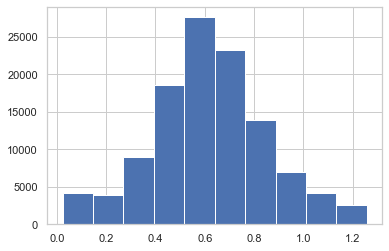

In [511]:
df_cleaned['rt'].hist();

now we will correct Used Hand column

by using the unique command we found out that some values are wrong, so we reconstruct the left and right hand values from the key column

In [512]:
df_cleaned['uhnd'].unique()

array(['r', 'l', nan, 'I', '0.bmp', '10.bmp'], dtype=object)

In [513]:
df_cleaned['uhnd'] = df_cleaned['key'].apply(lambda x: 'r' if x in ['o','p'] else ( 'l' if x in ['q','w'] else x))

now we will correct Stimulus column

in this column we keep only the number of pictures and remove useless parts like .bmp & Supplementary Material/ 

In [514]:
df_cleaned['stm'].unique()

array(['50.bmp', '70.bmp', '80.bmp', '60.bmp', '40.bmp', '0.bmp',
       '20.bmp', '10.bmp', '30.bmp', 'Supplementary Material/20.bmp',
       'Supplementary Material/60.bmp', 'Supplementary Material/70.bmp',
       'Supplementary Material/50.bmp', 'Supplementary Material/10.bmp',
       'Supplementary Material/40.bmp', 'Supplementary Material/30.bmp',
       'Supplementary Material/80.bmp', 'Supplementary Material/0.bmp'],
      dtype=object)

In [515]:
df_cleaned['stm'] = df_cleaned['stm'].apply(lambda x: re.findall(r'\d+', x)[0])

stimulus and position columns are unreconstuctable by other columns, so we remove any row that have NaN values in these columns


In [516]:
df_cleaned.dropna(subset=['stm', 'pos'], inplace=True)

also the size column has many Nan values and is useless, so we drop this column too

In [517]:
df_cleaned.drop('size', axis=1, inplace=True)

now lets look at Not-Null counts of columns, it seems that eye column has one Nan value. It's not so important and we will fill it by its previous row

In [518]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112419 entries, 3 to 121694
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   sbj     112419 non-null  object 
 1   stm     112419 non-null  object 
 2   rt      112419 non-null  float64
 3   key     112419 non-null  object 
 4   pos     112419 non-null  float64
 5   uhnd    112419 non-null  object 
 6   hndns   112419 non-null  object 
 7   eye     112418 non-null  object 
 8   sex     112419 non-null  object 
 9   age     112419 non-null  float64
 10  edu     112419 non-null  float64
dtypes: float64(4), object(7)
memory usage: 10.3+ MB


In [519]:
df_cleaned.fillna(method='bfill', inplace=True)

at the last we calculate the percentage of removed data. the percentage is more than 2 percent of primitive table, but it's inhevitable

In [520]:
df_cleaned.shape[0], df.shape[0]

(112419, 121695)

In [521]:
print( int((1-df_cleaned.shape[0]/df.shape[0])*100), '% of data has been removed')

7 % of data has been removed


In [562]:
final_df = df_cleaned.copy()

---
# Exploring the data

### First we add the asked columns to table

##### rt column in ms :

In [563]:
final_df['rt'] = final_df['rt']*1000

##### normal logaritm of rt :

In [564]:
final_df['lrt'] = np.log(final_df['rt'])

##### Eccentricity  :

In [565]:
final_df['ecc'] = final_df['pos'].apply(lambda x: 0 if x == 1 else (1 if x in [2,3,4,5,6,7] else 2))

##### Visual Fields :

In [566]:
final_df['vf'] = final_df['pos'].apply(lambda x: 0 if x == 1 else (1 if x in [2, 8,13] else 
                                                                  (2 if x in [3, 4, 9] else
                                                                  (3 if x in [5,10,11] else
                                                                  (4 if x in [6, 7,12] else 5)))))

##### Used Dominant Hand :

In [567]:
final_df['udh'] = np.where(final_df.uhnd == final_df.hndns, 1, 0)

##### accuracy column :

removing ' 40 ' stimulus from table :

In [592]:
EDA_df = final_df[final_df.stm != '40'].copy()

creating acc column :

In [593]:
acc = []
acc0 = EDA_df['key'].apply(lambda x: 'm' if x in ['w','p'] else 'f').to_list()
acc1 = EDA_df['stm'].apply(lambda x: 'm' if x in ['0' ,'10','20','30'] else 
                                    ('f' if x in ['50','60','70','80'] else x)).to_list()

for i in range(len(acc0)):
    if acc1[i] == acc0[i]:
        acc.append(1)
    else:
        acc.append(0)

In [594]:
EDA_df['acc'] = acc

##### Final table :

In [595]:
EDA_df.head()

,sbj,stm,rt,key,pos,uhnd,hndns,eye,sex,age,edu,lrt,ecc,vf,udh,acc
3,8101004202,50,925.6644,o,10.0,r,r,r,m,22.0,2.0,6.830512,2,3,1,1
5,8101004202,70,1163.9952,o,6.0,r,r,r,m,22.0,2.0,7.059614,1,4,1,1
6,8101004202,50,1023.1118,o,9.0,r,r,r,m,22.0,2.0,6.930604,2,2,1,1
8,8101004202,80,970.4250,o,10.0,r,r,r,m,22.0,2.0,6.877734,2,3,1,1
14,8101004202,60,1175.1443,p,13.0,r,r,r,m,22.0,2.0,7.069146,2,1,1,0


---

### Barplots & ANOVA test for Reaction Time

#### Reaction Time & Location

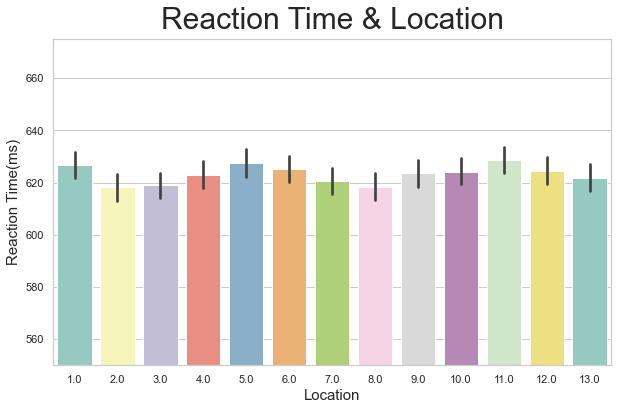

In [730]:
plt.figure(figsize=(10,6))
sns.barplot(x=EDA_df.pos, y=EDA_df.rt, palette='Set3')
plt.xlabel('Location', fontsize=15)
plt.ylabel('Reaction Time(ms)', fontsize=15)
plt.ylim(550,675)
plt.title('Reaction Time & Location', pad=10, fontsize=30)
plt.show();

In [694]:
model = ols('rt ~ C(pos)', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['rt & Location'])

,P_value,R_squared,AIC,BIC
rt & Location,0.051137,0.000209,1.372040e+06,1.372163e+06


#### Reaction Time & Visual Field

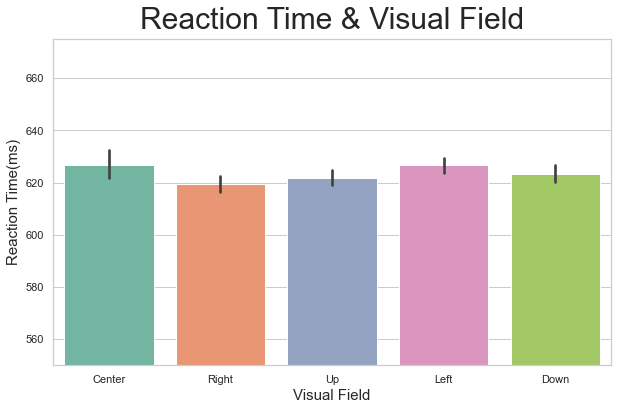

In [695]:
plt.figure(figsize=(10,6))
sns.barplot(x=EDA_df.vf, y=EDA_df.rt, palette='Set2')
plt.xticks([0,1,2,3,4],['Center','Right','Up','Left','Down'])
plt.xlabel('Visual Field', fontsize=15)
plt.ylabel('Reaction Time(ms)', fontsize=15)
plt.ylim(550,675)
plt.title('Reaction Time & Visual Field', pad=10, fontsize=30)
plt.show();

In [696]:
model = ols('rt ~ C(vf)', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['rt & Visual Field'])

,P_value,R_squared,AIC,BIC
rt & Visual Field,0.005929,0.000145,1.372030e+06,1.372078e+06


#### Reaction Time & Eccentricity

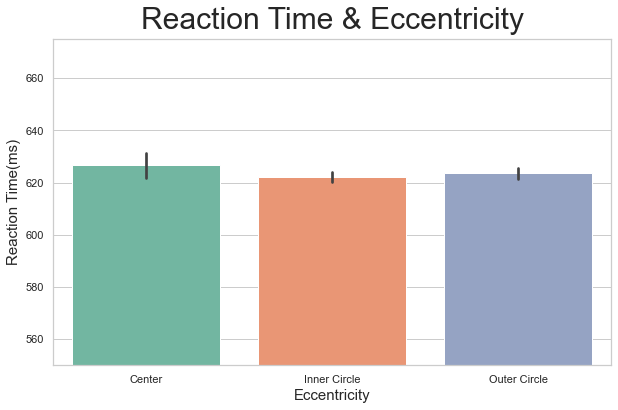

In [697]:
plt.figure(figsize=(10,6))
sns.barplot(x=EDA_df.ecc, y=EDA_df.rt, palette='Set2')
plt.xticks([0,1,2],['Center','Inner Circle','Outer Circle'])
plt.xlabel('Eccentricity', fontsize=15)
plt.ylabel('Reaction Time(ms)', fontsize=15)
plt.ylim(550,675)
plt.title('Reaction Time & Eccentricity', pad=10, fontsize=30)
plt.show();

In [698]:
model = ols('rt ~ C(ecc)', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['rt & Eccentricity'])

,P_value,R_squared,AIC,BIC
rt & Eccentricity,0.227933,0.00003,1.372037e+06,1.372066e+06


#### Reaction Time & Used Hand

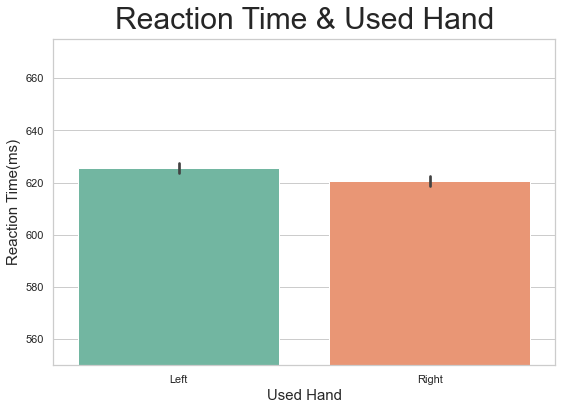

In [699]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.uhnd, y=EDA_df.rt, palette='Set2', order=['l', 'r'])
plt.xticks([0,1],['Left','Right'])
plt.xlabel('Used Hand', fontsize=15)
plt.ylabel('Reaction Time(ms)', fontsize=15)
plt.ylim(550,675)
plt.title('Reaction Time & Used Hand', pad=10, fontsize=30)
plt.show();

In [700]:
model = ols('rt ~ uhnd', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['rt & Used Hand'])

,P_value,R_squared,AIC,BIC
rt & Used Hand,0.000448,0.000123,1.372026e+06,1.372045e+06


#### Reaction Time & Handedness

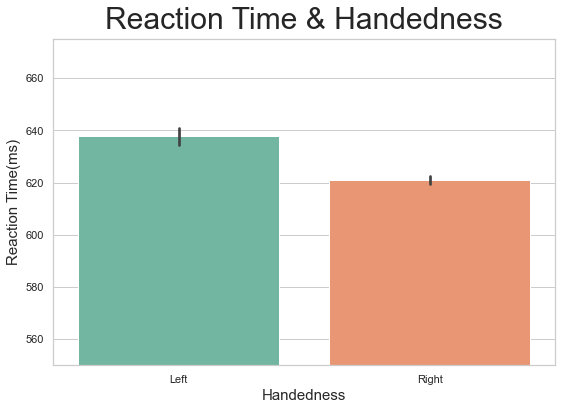

In [701]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.hndns, y=EDA_df.rt, palette='Set2', order=['l', 'r'])
plt.xticks([0,1],['Left','Right'])
plt.xlabel('Handedness', fontsize=15)
plt.ylabel('Reaction Time(ms)', fontsize=15)
plt.ylim(550,675)
plt.title('Reaction Time & Handedness', pad=10, fontsize=30)
plt.show();

In [702]:
model = ols('rt ~ hndns', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['rt & Handedness'])

,P_value,R_squared,AIC,BIC
rt & Handedness,1.248118e-14,0.000594,1.371979e+06,1.371998e+06


#### Reaction Time & Used Dominant Hand

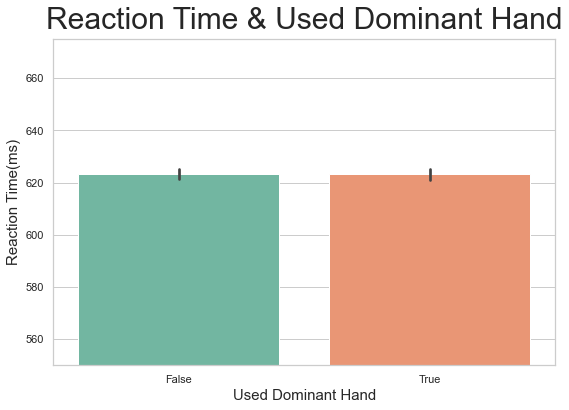

In [703]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.udh, y=EDA_df.rt, palette='Set2')
plt.xticks([0,1],['False','True'])
plt.xlabel('Used Dominant Hand', fontsize=15)
plt.ylabel('Reaction Time(ms)', fontsize=15)
plt.ylim(550,675)
plt.title('Reaction Time & Used Dominant Hand', pad=10, fontsize=30)
plt.show();

In [704]:
model = ols('rt ~ C(udh)', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['rt & Used Dominant Hand'])

,P_value,R_squared,AIC,BIC
rt & Used Dominant Hand,0.917928,1.061241e-07,1.372038e+06,1.372057e+06


#### Reaction Time & Gender

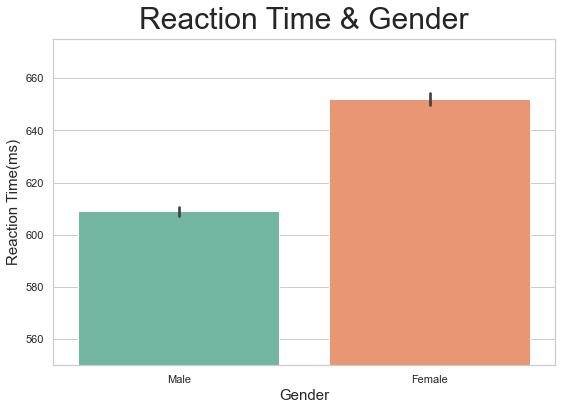

In [705]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.sex, y=EDA_df.rt, palette='Set2')
plt.xticks([0,1],['Male','Female'])
plt.xlabel('Gender', fontsize=15)
plt.ylabel('Reaction Time(ms)', fontsize=15)
plt.ylim(550,675)
plt.title('Reaction Time & Gender', pad=10, fontsize=30)
plt.show();

In [706]:
model = ols('rt ~ sex', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['rt & Gender'])

,P_value,R_squared,AIC,BIC
rt & Gender,4.107114e-172,0.007787,1.371256e+06,1.371275e+06


#### Reaction Time & Eyedness

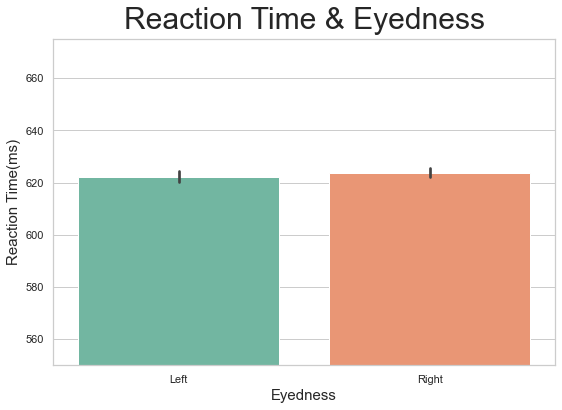

In [707]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.eye, y=EDA_df.rt, palette='Set2', order=['l', 'r'])
plt.xticks([0,1],['Left','Right'])
plt.xlabel('Eyedness', fontsize=15)
plt.ylabel('Reaction Time(ms)', fontsize=15)
plt.ylim(550,675)
plt.title('Reaction Time & Eyedness', pad=10, fontsize=30)
plt.show();

In [708]:
model = ols('rt ~ eye', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['rt & Eyedness'])

,P_value,R_squared,AIC,BIC
rt & Eyedness,0.267876,0.000012,1.372037e+06,1.372056e+06


---

### Barplots & ANOVA test for Accuracy

#### Accuracy & Location

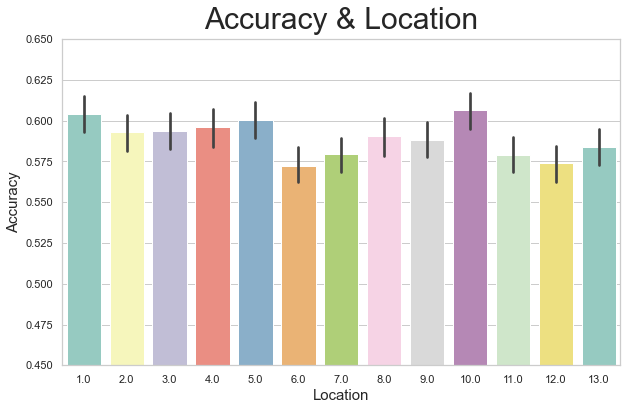

In [729]:
plt.figure(figsize=(10,6))
sns.barplot(x=EDA_df.pos, y=EDA_df.acc, palette='Set3')
plt.xlabel('Location', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.45,0.65)
plt.title('Accuracy & Location', pad=10, fontsize=30)
plt.show();

In [710]:
model = ols('acc ~ C(pos)', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['acc & Location'])

,P_value,R_squared,AIC,BIC
acc & Location,0.000005,0.000468,141972.152729,142095.828038


#### Accuracy & Visual Field

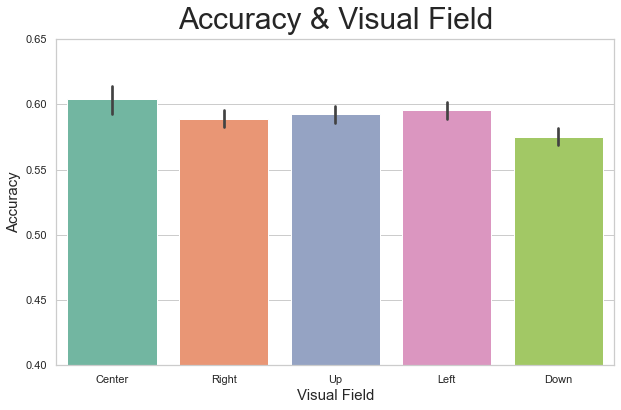

In [711]:
plt.figure(figsize=(10,6))
sns.barplot(x=EDA_df.vf, y=EDA_df.acc, palette='Set2')
plt.xticks([0,1,2,3,4],['Center','Right','Up','Left','Down'])
plt.xlabel('Visual Field', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.4,0.65)
plt.title('Accuracy & Visual Field', pad=10, fontsize=30)
plt.show();

In [712]:
model = ols('acc ~ C(vf)', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['acc & Visual Field'])

,P_value,R_squared,AIC,BIC
acc & Visual Field,0.000004,0.000303,141972.740622,142020.308049


#### Accuracy & Eccentricity

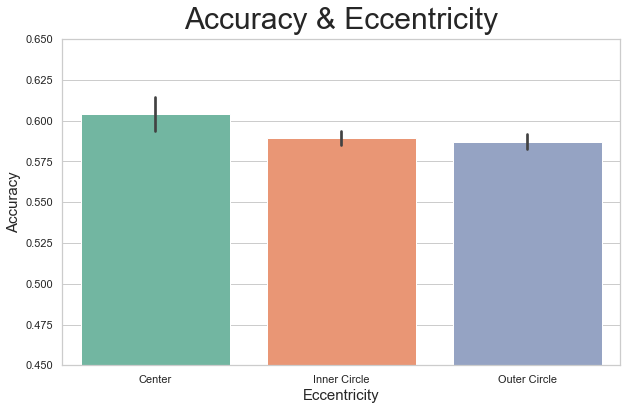

In [713]:
plt.figure(figsize=(10,6))
sns.barplot(x=EDA_df.ecc, y=EDA_df.acc, palette='Set2')
plt.xticks([0,1,2],['Center','Inner Circle','Outer Circle'])
plt.xlabel('Eccentricity', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.45,0.65)
plt.title('Accuracy & Eccentricity', pad=10, fontsize=30)
plt.show();

In [714]:
model = ols('acc ~ C(ecc)', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['acc & Eccentricity'])

,P_value,R_squared,AIC,BIC
acc & Eccentricity,0.020782,0.000077,141991.265891,142019.806347


#### Accuracy & Used Hand

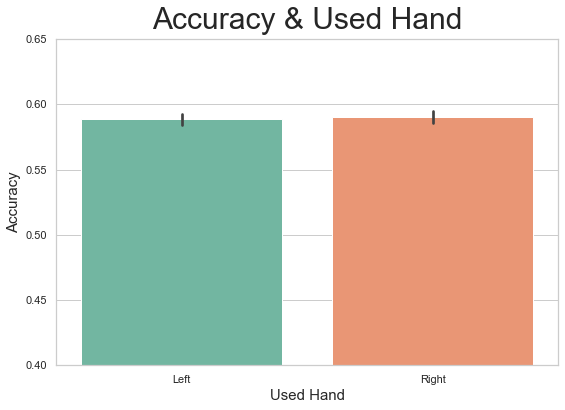

In [715]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.uhnd, y=EDA_df.acc, palette='Set2', order=['l', 'r'])
plt.xticks([0,1],['Left','Right'])
plt.xlabel('Used Hand', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.4,0.65)
plt.title('Accuracy & Used Hand', pad=10, fontsize=30)
plt.show();

In [716]:
model = ols('acc ~ uhnd', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['acc & Used Hand'])

,P_value,R_squared,AIC,BIC
acc & Used Hand,0.549522,0.000004,141996.655309,142015.682279


#### Accuracy & Handedness

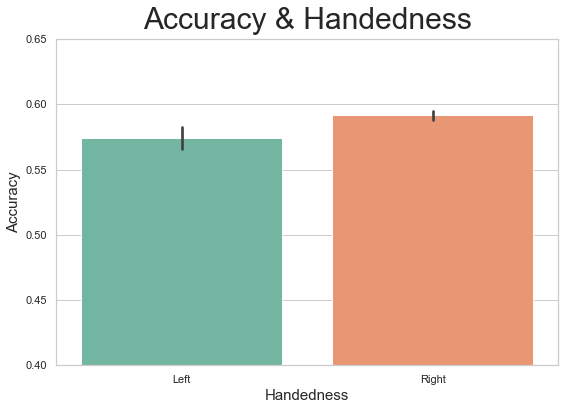

In [717]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.hndns, y=EDA_df.acc, palette='Set2', order=['l', 'r'])
plt.xticks([0,1],['Left','Right'])
plt.xlabel('Handedness', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.4,0.65)
plt.title('Accuracy & Handedness', pad=10, fontsize=30)
plt.show();

In [718]:
model = ols('acc ~ hndns', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['acc & Handedness'])

,P_value,R_squared,AIC,BIC
acc & Handedness,0.000138,0.000145,141982.478862,142001.505832


#### Accuracy & Used Dominant Hand

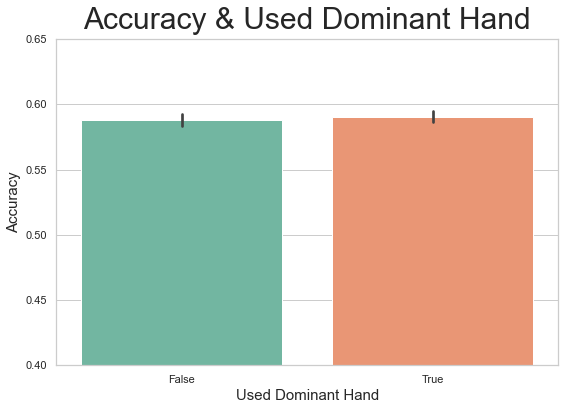

In [719]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.udh, y=EDA_df.acc, palette='Set2')
plt.xticks([0,1],['False','True'])
plt.xlabel('Used Dominant Hand', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.4,0.65)
plt.title('Accuracy & Used Dominant Hand', pad=10, fontsize=30)
plt.show();

In [720]:
model = ols('acc ~ C(udh)', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['acc & Used Dominant Hand'])

,P_value,R_squared,AIC,BIC
acc & Used Dominant Hand,0.38733,0.000007,141996.266167,142015.293138


#### Accuracy & Gender

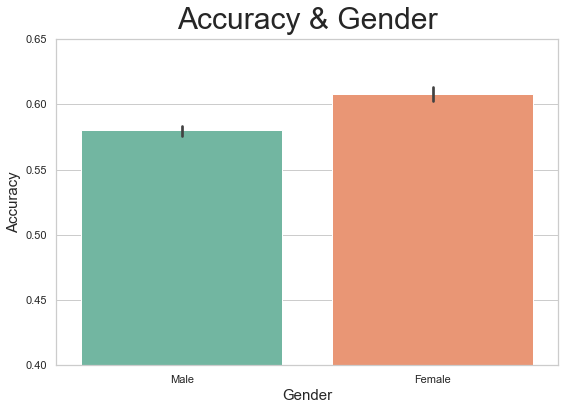

In [721]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.sex, y=EDA_df.acc, palette='Set2')
plt.xticks([0,1],['Male','Female'])
plt.xlabel('Gender', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.4,0.65)
plt.title('Accuracy & Gender', pad=10, fontsize=30)
plt.show();

In [722]:
model = ols('acc ~ sex', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['acc & Gender'])

,P_value,R_squared,AIC,BIC
acc & Gender,2.605562e-17,0.000716,141925.38911,141944.41608


#### Accuracy & Eyedness

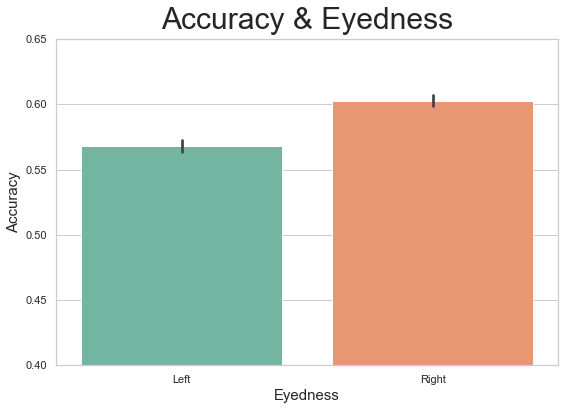

In [723]:
plt.figure(figsize=(9,6))
sns.barplot(x=EDA_df.eye, y=EDA_df.acc, palette='Set2', order=['l', 'r'])
plt.xticks([0,1],['Left','Right'])
plt.xlabel('Eyedness', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.4,0.65)
plt.title('Accuracy & Eyedness', pad=10, fontsize=30)
plt.show();

In [724]:
model = ols('acc ~ eye', data = EDA_df).fit()
pd.DataFrame({'P_value':model.f_pvalue, 'R_squared':model.rsquared , 'AIC':model.aic , 'BIC':model.bic}, 
             index=['acc & Eyedness'])

,P_value,R_squared,AIC,BIC
acc & Eyedness,2.156439e-27,0.001174,141879.443135,141898.470105


---
# Prediction of Behavioral Characteristics

### Linear Regression for Reaction Time

In [842]:
model1 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + C(pos)*hndns + 
                     C(pos)*eye + C(pos)*sex + C(pos)*C(ecc) + C(pos)*C(vf) + C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model1.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(pos)[T.12.0]:hndns[T.r]    0.961525
dtype: float64


In [849]:
model2 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + 
                     C(pos)*eye + C(pos)*sex + C(pos)*C(ecc) + C(pos)*C(vf) + C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model2.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(pos)[T.7.0]:eye[T.r]    0.983065
dtype: float64


In [850]:
model3 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + 
                     C(pos)*sex + C(pos)*C(ecc) + C(pos)*C(vf) + C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model3.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(pos)[T.9.0]:sex[T.m]    0.992883
dtype: float64


In [851]:
model4 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + 
                     C(pos)*C(ecc) + C(pos)*C(vf) + C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model4.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(pos)[T.9.0]:C(ecc)[T.1]    0.97611
dtype: float64


In [852]:
model5 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + 
                     C(pos)*C(vf) + C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model5.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 uhnd[T.r]:C(vf)[T.3]    0.980098
dtype: float64


In [853]:
model6 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + 
                     C(pos)*C(vf) + C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model6.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(pos)[T.4.0]:C(vf)[T.1]    0.964174
dtype: float64


In [854]:
model7 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + 
                     C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model7.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(ecc)[T.1]:C(vf)[T.2]    0.79189
dtype: float64


In [855]:
model8 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + 
                     C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model8.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 uhnd[T.r]:C(ecc)[T.2]    0.982785
dtype: float64


In [856]:
model9 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + C(pos)*uhnd + 
                     C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model9.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(pos)[T.5.0]:uhnd[T.r]    0.988093
dtype: float64


In [857]:
model10 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + 
                     C(pos)*C(udh) + uhnd*hndns + uhnd*eye + 
                     uhnd*sex + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                     hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                     sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model10.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(pos)[T.2.0]:C(udh)[T.1]    0.98781
dtype: float64


In [858]:
model11 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + uhnd*hndns + uhnd*eye + 
                      uhnd*sex + uhnd*C(udh) + hndns*eye + hndns*sex + hndns*C(ecc) + 
                      hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model11.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 hndns[T.r]:sex[T.m]    0.958957
dtype: float64


In [859]:
model12 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + uhnd*hndns + uhnd*eye + 
                      uhnd*sex + uhnd*C(udh) + hndns*eye + hndns*C(ecc) + 
                      hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model12.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 hndns[T.r]:C(udh)[T.1]    0.962795
dtype: float64


In [860]:
model13 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + uhnd*hndns + uhnd*eye + 
                      uhnd*sex + uhnd*C(udh) + hndns*eye + hndns*C(ecc) + 
                      hndns*C(vf) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model13.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(vf)[T.2]    0.862085
dtype: float64


In [861]:
model14 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(udh) + uhnd*hndns + uhnd*eye + 
                      uhnd*sex + uhnd*C(udh) + hndns*eye + hndns*C(ecc) + 
                      hndns*C(vf) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model14.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 uhnd[T.r]:C(udh)[T.1]    0.699963
dtype: float64


In [862]:
model15 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(udh) + uhnd*hndns + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + 
                      hndns*C(vf) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model15.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 hndns[T.r]:C(vf)[T.3]    0.974265
dtype: float64


In [863]:
model16 = ols('''rt ~ C(pos) + uhnd + hndns + eye + sex + C(ecc) + C(udh) + uhnd*hndns + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model16.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 uhnd[T.r]    0.96098
dtype: float64


In [864]:
model17 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*hndns + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model17.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 uhnd[T.r]    0.881295
dtype: float64


In [865]:
model18 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model18.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(vf)[T.2]    0.835693
dtype: float64


In [866]:
model19 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + eye*sex + eye*C(ecc) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model19.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 sex[T.m]:C(vf)[T.4]    0.859232
dtype: float64


In [867]:
model20 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + eye*sex + eye*C(ecc) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(udh) + C(ecc)*C(udh) + C(vf)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model20.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(vf)[T.2]    0.940551
dtype: float64


In [868]:
model21 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + eye*sex + eye*C(ecc) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(udh) + C(ecc)*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model21.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(ecc)[T.2]:C(udh)[T.1]    0.929793
dtype: float64


In [869]:
model22 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + eye*sex + eye*C(ecc) + eye*C(udh) + sex*C(ecc) + 
                      sex*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model22.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 eye[T.r]:C(ecc)[T.2]    0.57977
dtype: float64


In [870]:
model23 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + hndns*C(ecc) + eye*sex + eye*C(udh) + sex*C(ecc) + 
                      sex*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model23.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 hndns[T.r]:C(ecc)[T.1]    0.331929
dtype: float64


In [871]:
model24 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + eye*sex + eye*C(udh) + sex*C(ecc) + 
                      sex*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model24.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 sex[T.m]:C(ecc)[T.1]    0.296355
dtype: float64


In [872]:
model25 = ols('''rt ~ C(pos) + hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + eye*sex + eye*C(udh) + 
                      sex*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model25.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(pos)[T.8.0]    0.178128
dtype: float64


In [873]:
model26 = ols('''rt ~ hndns + eye + sex + C(ecc) + C(udh) + uhnd*eye + 
                      uhnd*sex + hndns*eye + eye*sex + eye*C(udh) + 
                      sex*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model26.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(udh)[T.1]    0.665134
dtype: float64


In [874]:
model27 = ols('''rt ~ hndns + eye + sex + C(ecc) + uhnd*eye + 
                      uhnd*sex + hndns*eye + eye*sex + eye*C(udh) + 
                      sex*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model27.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(ecc)[T.2]    0.283122
dtype: float64


In [875]:
model28 = ols('''rt ~ hndns + eye + sex + uhnd*eye + 
                      uhnd*sex + hndns*eye + eye*sex + eye*C(udh) + 
                      sex*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model28.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(udh)[T.1]    0.828947
dtype: float64


In [876]:
model29 = ols('''rt ~ hndns + eye + sex + uhnd*eye + 
                      uhnd*sex + hndns*eye + eye*sex + 
                      sex*C(udh)''', data = final_df).fit()

print('maximum p-value is for :', '\n', model29.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 C(udh)[T.1]    0.826353
dtype: float64


In [877]:
model30 = ols('''rt ~ hndns + eye + sex + uhnd*eye + 
                      uhnd*sex + hndns*eye + eye*sex''', data = final_df).fit()

print('maximum p-value is for :', '\n', model30.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 uhnd[T.r]    0.72576
dtype: float64


In [878]:
model31 = ols('''rt ~ hndns + eye + sex + uhnd*sex + hndns*eye + eye*sex''', data = final_df).fit()

print('maximum p-value is for :', '\n', model31.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 hndns[T.r]:eye[T.r]    0.145468
dtype: float64


In [879]:
model32 = ols('''rt ~ hndns + eye + sex + uhnd*sex + eye*sex''', data = final_df).fit()

print('maximum p-value is for :', '\n', model32.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 uhnd[T.r]    0.101206
dtype: float64


In [880]:
model33 = ols('''rt ~ hndns + eye + sex + eye*sex''', data = final_df).fit()

print('maximum p-value is for :', '\n', model33.pvalues.sort_values(ascending=False)[:1])

maximum p-value is for : 
 eye[T.r]:sex[T.m]    0.000254
dtype: float64


In [884]:
print(model33.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     307.7
Date:                Wed, 30 Mar 2022   Prob (F-statistic):          8.85e-264
Time:                        21:41:11   Log-Likelihood:            -7.7031e+05
No. Observations:              112419   AIC:                         1.541e+06
Df Residuals:                  112414   BIC:                         1.541e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           681.3829      2.84

### Logistic Regression for Accuracy

In [914]:
lr_model1 = logit('''acc ~ pos + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + uhnd*hndns + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + 
                           C(vf)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model1.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.674921
         Iterations: 35
maximum p-value is for : 
 uhnd[T.r]:hndns[T.r]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [916]:
lr_model2 = logit('''acc ~ pos + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + hndns*C(udh) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + 
                           C(vf)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model2.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.674921
         Iterations: 35
maximum p-value is for : 
 hndns[T.r]:C(udh)[T.1]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [917]:
lr_model3 = logit('''acc ~ pos + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(ecc) + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + 
                           C(vf)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model3.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.674921
         Iterations: 35
maximum p-value is for : 
 eye[T.r]:C(ecc)[T.1]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [918]:
lr_model4 = logit('''acc ~ pos + uhnd + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + 
                           C(vf)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model4.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.674937
         Iterations: 35
maximum p-value is for : 
 uhnd[T.r]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [919]:
lr_model5 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(vf) + sex*C(udh) + C(ecc)*C(vf) + C(ecc)*C(udh) + 
                           C(vf)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model5.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.674937
         Iterations: 35
maximum p-value is for : 
 C(ecc)[T.2]:C(vf)[T.4]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [920]:
lr_model6 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(vf) + sex*C(udh) + C(ecc)*C(udh) + 
                           C(vf)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model6.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.674988
         Iterations: 35
maximum p-value is for : 
 C(vf)[T.1]:C(udh)[T.1]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [921]:
lr_model7 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(vf) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(vf) + sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model7.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675010
         Iterations: 35
maximum p-value is for : 
 uhnd[T.r]:C(vf)[T.2]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [922]:
lr_model8 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(vf) + sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model8.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675031
         Iterations: 35
maximum p-value is for : 
 sex[T.m]:C(vf)[T.2]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [923]:
lr_model9 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(vf) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model9.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675045
         Iterations: 35
maximum p-value is for : 
 pos:C(vf)[T.2]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [924]:
lr_model10 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(ecc) + sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model10.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675055
         Iterations: 35
maximum p-value is for : 
 sex[T.m]:C(ecc)[T.2]    0.988787
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [925]:
lr_model11 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*uhnd + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model11.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675063
         Iterations: 35
maximum p-value is for : 
 uhnd[T.r]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [926]:
lr_model12 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(ecc) + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model12.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675063
         Iterations: 35
maximum p-value is for : 
 pos:C(ecc)[T.1]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [927]:
lr_model13 = logit('''acc ~ pos + hndns + eye + sex + C(ecc) + C(vf) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model13.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675064
         Iterations: 35
maximum p-value is for : 
 hndns[T.r]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [928]:
lr_model14 = logit('''acc ~ pos + eye + sex + C(ecc) + C(vf) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + hndns*C(vf) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model14.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675064
         Iterations: 35
maximum p-value is for : 
 hndns[T.r]:C(vf)[T.3]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [929]:
lr_model15 = logit('''acc ~ pos + eye + sex + C(ecc) + C(vf) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model15.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675073
         Iterations: 35
maximum p-value is for : 
 C(vf)[T.4]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [930]:
lr_model16 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(udh) + 
                           uhnd*eye + uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model16.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675073
         Iterations: 35
maximum p-value is for : 
 uhnd[T.r]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [931]:
lr_model17 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(udh) + 
                           uhnd*sex + uhnd*C(ecc) + uhnd*C(udh) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model17.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675073
         Iterations: 35
maximum p-value is for : 
 uhnd[T.r]:C(udh)[T.1]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [933]:
lr_model18 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(udh) + uhnd*sex + uhnd*C(ecc) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(vf) + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model18.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675073
         Iterations: 35
maximum p-value is for : 
 C(vf)[T.4]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [934]:
lr_model19 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(udh) + uhnd*sex + uhnd*C(ecc) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(udh) + 
                           sex*C(udh) + C(ecc)*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model19.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675160
         Iterations: 35
maximum p-value is for : 
 C(ecc)[T.2]:C(udh)[T.1]    0.848718
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [935]:
lr_model20 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + pos*hndns + 
                           pos*eye + pos*sex + pos*C(udh) + uhnd*sex + uhnd*C(ecc) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(udh) + 
                           sex*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model20.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675162
         Iterations: 35
maximum p-value is for : 
 hndns[T.r]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [936]:
lr_model21 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + 
                           pos*eye + pos*sex + pos*C(udh) + uhnd*sex + uhnd*C(ecc) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(udh) + 
                           sex*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model21.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675186
         Iterations: 35
maximum p-value is for : 
 sex[T.m]:C(udh)[T.1]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [937]:
lr_model22 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + 
                           pos*eye + pos*sex + pos*C(udh) + uhnd*sex + uhnd*C(ecc) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model22.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675186
         Iterations: 35
maximum p-value is for : 
 pos:eye[T.r]    0.90464
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [938]:
lr_model23 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + 
                           pos*sex + pos*C(udh) + uhnd*sex + uhnd*C(ecc) + hndns*eye + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model23.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675186
         Iterations 22
maximum p-value is for : 
 hndns[T.r]    1.0
dtype: float64


In [939]:
lr_model24 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + 
                           pos*sex + pos*C(udh) + uhnd*sex + uhnd*C(ecc) + hndns*sex + 
                           hndns*C(ecc) + eye*sex + eye*C(udh)''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model24.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675372
         Iterations 31
maximum p-value is for : 
 eye[T.r]:C(udh)[T.1]    0.765771
dtype: float64


In [940]:
lr_model25 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + 
                           pos*sex + pos*C(udh) + uhnd*sex + uhnd*C(ecc) + hndns*sex + 
                           hndns*C(ecc) + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model25.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675373
         Iterations: 35
maximum p-value is for : 
 uhnd[T.r]:sex[T.m]    0.747082
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [941]:
lr_model26 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + 
                           pos*sex + pos*C(udh) + uhnd*C(ecc) + hndns*sex + 
                           hndns*C(ecc) + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model26.pvalues.sort_values(ascending=False)[:1])

         Current function value: 0.675373
         Iterations: 35
maximum p-value is for : 
 hndns[T.r]:sex[T.m]    1.0
dtype: float64


C:\Users\MAHYAR\anaconda3\envs\DA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [942]:
lr_model27 = logit('''acc ~ pos + eye + sex + C(ecc) + C(udh) + 
                           pos*sex + pos*C(udh) + uhnd*C(ecc) + hndns*C(ecc) + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model27.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675373
         Iterations 4
maximum p-value is for : 
 C(ecc)[T.1]    0.487247
dtype: float64


In [943]:
lr_model28 = logit('''acc ~ pos + eye + sex + C(udh) + 
                           pos*sex + pos*C(udh) + uhnd*C(ecc) + hndns*C(ecc) + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model28.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675373
         Iterations 4
maximum p-value is for : 
 C(ecc)[T.1]    0.487247
dtype: float64


In [944]:
lr_model29 = logit('''acc ~ pos + eye + sex + C(udh) + 
                           pos*sex + pos*C(udh) + hndns*C(ecc) + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model29.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675379
         Iterations 4
maximum p-value is for : 
 pos:C(udh)[T.1]    0.439214
dtype: float64


In [945]:
lr_model30 = logit('''acc ~ pos + eye + sex + C(udh) + 
                           pos*sex + hndns*C(ecc) + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model30.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675382
         Iterations 4
maximum p-value is for : 
 C(udh)[T.1]    0.372811
dtype: float64


In [946]:
lr_model31 = logit('''acc ~ pos + eye + sex + pos*sex + hndns*C(ecc) + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model31.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675386
         Iterations 4
maximum p-value is for : 
 hndns[T.r]:C(ecc)[T.2]    0.290587
dtype: float64


In [947]:
lr_model32 = logit('''acc ~ pos + eye + sex + pos*sex + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model32.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675446
         Iterations 4
maximum p-value is for : 
 pos    0.609735
dtype: float64


In [948]:
lr_model33 = logit('''acc ~ eye + sex + pos*sex + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model33.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675446
         Iterations 4
maximum p-value is for : 
 pos    0.609735
dtype: float64


In [949]:
lr_model34 = logit('''acc ~ eye + sex + eye*sex''', data = EDA_df).fit()

print('maximum p-value is for :', '\n', lr_model34.pvalues.sort_values(ascending=False)[:1])

Optimization terminated successfully.
         Current function value: 0.675513
         Iterations 4
maximum p-value is for : 
 sex[T.m]    0.016066
dtype: float64


In [950]:
print(lr_model34.summary())

                           Logit Regression Results                           
Dep. Variable:                    acc   No. Observations:               100056
Model:                          Logit   Df Residuals:                   100052
Method:                           MLE   Df Model:                            3
Date:                Wed, 30 Mar 2022   Pseudo R-squ.:                0.002341
Time:                        22:48:17   Log-Likelihood:                -67589.
converged:                       True   LL-Null:                       -67748.
Covariance Type:            nonrobust   LLR p-value:                 1.922e-68
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2424      0.017     14.315      0.000       0.209       0.276
eye[T.r]              0.3501      0.023     15.380      0.000       0.305       0.395
sex[T.m]              0.

---

# Psychometric Fitting

In [ ]:
# final_df.applymap(lambda x: 0 if x in ['l','f'] else (1 if x in ['r','m'] else x))

---

# Spread of PSEs

---

# Reaction Time Correlation to Choice Complexity

---

# Representational Similarity Analysis (RSA)